# Blockade Interaction in a Magnetic Field

The interaction between Rydberg atoms is strongly influenced by external electric and magnetic fields. A small magnetic field for instance lifts the Zeeman degeneracy and thus strengthens the Rydberg blockade, especially if there is a non-zero angle between the interatomic and the quantization axis. This has been discussed in M. Saffman, T. G. Walker, and K. Mølmer, “Quantum information with Rydberg atoms,” [Rev. Mod. Phys. 82, 2313 (2010)](https://dx.doi.org/10.1103/RevModPhys.82.2313) ([Fig. 13](https://journals.aps.org/rmp/article/10.1103/RevModPhys.82.2313/figures/13/medium)).  Here we show how to reproduce this result using pairinteraction. The final Python script is available on [GitHub](https://github.com/pairinteraction/pairinteraction/blob/master/doc/sphinx/examples/comparison_to_saffman_fig13.py).

Ahead of our Python code, we call an IPython magic function to make the output of plotting commands displayed inline within the  notebook.

In [1]:
%matplotlib inline

Our code starts with loading the required modules for the computation. We will make use of pairinteraction's parallel capacities which is why we load the `multiprocessing` module. We use the module `pireal` as the Hamiltonian matrix of our system will be purely real-valued (if one considers electric or magnetic fields with a non-zero $y$-value, the Hamiltonian is complex due to the chosen definition of the spherical basis and one has to use `picomplex`).

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import sys
if sys.platform == "darwin": sys.path.append("/Applications/pairinteraction.app/Contents/Resources")
elif sys.platform == "win32": sys.path.append("C:\Program Files\pairinteraction")
from libpairinteraction import pireal as pi

We begin by defining some constants of our calculation: the spatial separation of the Rydberg atoms and a range of magnetic field we want to iterate over.  The units of the respective quantities are given as comments.

In [3]:
distance = 10 # µm
bfields = np.linspace(0, 20, 200) # Gauss

Now, we use pairinteraction's `StateOne` class to define the single-atom state $\left|43d_{5/2},m_j=1/2\right\rangle$ of a Rubudium atom.

In [4]:
state_one = pi.StateOne("Rb", 43, 2, 2.5, 0.5)

To speed up the calculation, pairinteraction caches intermediate results, like matrix elements, for reuse.  Therefore we create a cache directory, dedicated to such files.

In [5]:
if not os.path.exists("./cache"):
    os.makedirs("./cache")

Next, we define how to set up the single atom system.  We do this using a function, so we can easily create systems with the magnetic field as a parameter.  Inside the function we create a new system by passing the `state_one` and the cache directory we created to `SystemOne`.

Because energies are calculated non-perturbatively, we have to choose cutoffs on states which can couple to `state_one`.  This is done by means of the `restrict...` functions in `SystemOne`.

Finally, we set the magnetic field to point in $z$-direction with the magnitude given by the argument.

In [6]:
def setup_system_one(bfield):
    system_one = pi.SystemOne(state_one.element, "./cache")
    system_one.restrictEnergy(state_one.energy-100, state_one.energy+100)
    system_one.restrictN(state_one.n-2, state_one.n+2)
    system_one.restrictL(state_one.l-2, state_one.l+2)
    system_one.setBfield([0, 0, bfield])
    return system_one

To investigate the $\left|43d_{5/2},m_j=1/2;43d_{5/2},m_j=1/2\right\rangle$ pair state, we easily combine the same single-atom state twice into a pair state using `StateTwo`.

In [7]:
state_two = pi.StateTwo(state_one, state_one)

Akin to the single atom system, we now define how to create a two atom system.  We want to parametrize this in terms of the single atom system and the interaction angle.

We compose a `SystemTwo` from two `system_one` because we are looking at two identical atoms.  Again we have to restrict the energy range for coupling.  Then we proceed to set the distance between the two atoms and the interaction angle.

To speed up the calculation, we can tell pairinteraction that this system will have some symmetries.

In [8]:
def setup_system_two(system_one,angle):
    system_two = pi.SystemTwo(system_one, system_one, "./cache")
    system_two.restrictEnergy(state_two.energy-5, state_two.energy+5)
    system_two.setDistance(10)
    system_two.setAngle(angle)
    if angle == 0: system_two.setConservedMomentaUnderRotation([int(2*state_one.m)])
    system_two.setConservedParityUnderInversion(pi.ODD)
    system_two.setConservedParityUnderPermutation(pi.ODD)
    return system_two

Now, we can use the definitions from above to compose our calculation.

In [9]:
def getEnergies(bfield):
    # Set up one atom system
    system_one = setup_system_one(bfield)
    system_one.diagonalize()

    # Calculate Zeeman shift
    zeemanshift = 2*system_one.diagonal[system_one.getVectorindex(state_one)]
    
    # Set up two atom system
    system_two = setup_system_two(system_one,angle)
    system_two.diagonalize()
    
    # Calculate blockade interaction
    eigenenergies = (system_two.diagonal-zeemanshift)*1e3 # MHz
    overlaps = system_two.getOverlap(state_two)
    blockade = 1/np.sqrt(np.sum(overlaps/eigenenergies**2))
    
    return blockade

With a little boiler-plate, we can then calculate and plot the result with `matplotlib`.

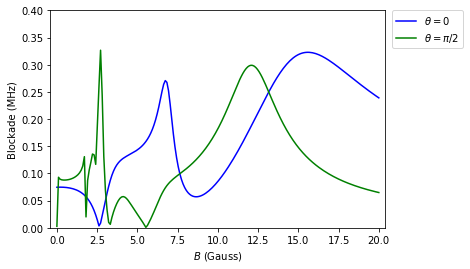

In [15]:
if __name__ ==  '__main__':
    plt.xlabel(r"$B$ (Gauss)")
    plt.ylabel(r"Blockade (MHz)")
    plt.xlim(-0.4,20.4)
    plt.ylim(0,0.4)

    angle = 0 # rad
    with Pool() as pool:
        energies1 = pool.map(getEnergies, bfields)

    angle = np.pi/2 # rad
    with Pool() as pool:
        energies2 = pool.map(getEnergies, bfields)

    plt.plot(bfields, energies1, 'b-', label=r"$\theta = 0$")
    plt.plot(bfields, energies2, 'g-', label=r"$\theta = \pi/2$")
    plt.legend(loc=2, bbox_to_anchor=(1.02, 1), borderaxespad=0);